In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from matplotlib import patches
from matplotlib.animation import ArtistAnimation
from IPython import display

In [2]:
class DifferentialDriveRobot():
    def __init__(self,
                 wheel_base: float = 1,  # [m] distance between wheels
                 robot_width=1,  # [m]
                 robot_length=1,  # [m]
                 max_linear_vel: float = 2.0,  # [m/s]
                 max_angular_vel: float = 2.0,  # [rad/s]
                 obstacle_circles: np.ndarray = np.array([[-2.0, 1.0, 1.0], [2.0, -1.0, 1.0]]),  # [obs_x, obs_y, obs_radius]
                 delta_t: float = 0.05,  # [s]
                 visualize: bool = True,
               ) -> None:
        """state variables:
            x: x-axis position [m]
            y: y-axis position [m]
            yaw: orientation [rad]
        control input:
            v: linear velocity [m/s]
            w: angular velocity [rad/s]
        """
        # robot parameters
        self.wheel_base = wheel_base  # [m] distance between wheels
        self.robot_w = robot_width
        self.robot_l = robot_length
        self.max_linear_vel = max_linear_vel  # [m/s]
        self.max_angular_vel = max_angular_vel  # [rad/s]
        self.delta_t = delta_t  # [s]
        # obstacle parameters
        self.obstacle_circles = obstacle_circles
        # visualization settings
        self.view_x_lim_min, self.view_x_lim_max = -10.0, 10.0
        self.view_y_lim_min, self.view_y_lim_max = -10.0, 10.0
        # reset environment
        self.visualize_flag = visualize
        self.reset()

    def reset(self,
              init_state: np.ndarray = np.array([0.0, 0.0, 0.0]),  # [x, y, yaw]
             ) -> None:
        # reset state variables
        self.state = init_state
        # clear animation frames
        self.frames = []

        if self.visualize_flag:
            # prepare figure
            self.fig = plt.figure(figsize=(5, 5))
            self.main_ax = plt.subplot2grid((1, 1), (0, 0))
            # graph layout settings
            # main view
            self.main_ax.set_aspect('auto')
            self.main_ax.set_xlim(self.view_x_lim_min, self.view_x_lim_max)
            self.main_ax.set_ylim(self.view_y_lim_min, self.view_y_lim_max)
            self.main_ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            self.main_ax.tick_params(bottom=False, left=False, right=False, top=False)
            # apply tight layout
            self.fig.tight_layout()

    def update(self,
               u: np.ndarray,
               delta_t: float = 0.0,
               append_frame: bool = True,
               # predicted optimal trajectory from dwa
               optimal_traj: np.ndarray = np.empty(0),
               sampled_traj_list: np.ndarray = np.empty(0),  # sampled trajectories from dwa
              ) -> None:
        # keep previous states
        x, y, yaw = self.state
        # prepare params
        dt = self.delta_t if delta_t == 0.0 else delta_t
        # limit control inputs
        v = np.clip(u[0], -self.max_linear_vel, self.max_linear_vel)
        w = np.clip(u[1], -self.max_angular_vel, self.max_angular_vel)
        # update state variables using differential drive kinematics
        new_x = x + v * np.cos(yaw) * dt
        new_y = y + v * np.sin(yaw) * dt
        new_yaw = yaw + w * dt
        self.state = np.array([new_x, new_y, new_yaw])
        # record frame
        if append_frame:
            self.append_frame(v, w, optimal_traj, sampled_traj_list)

    def get_state(self) -> np.ndarray:
        return self.state.copy()

    def append_frame(self, v: float, w: float, optimal_traj: np.ndarray, sampled_traj_list: np.ndarray) -> list:
        # get current states
        x, y, yaw = self.state
        # draw the robot shape
        vw, vl = self.robot_w, self.robot_l
        robot_shape_x = [- vl, - vl, + vl, + vl, - vl, - vl]
        robot_shape_y = [0.0, + vw, + vw, - vw, - vw, 0.0]
        rotated_robot_shape_x, rotated_robot_shape_y = \
            self._affine_transform(robot_shape_x, robot_shape_y, yaw, [0, 0])
        frame = self.main_ax.plot(rotated_robot_shape_x, rotated_robot_shape_y, color='black', linewidth=2.0, zorder=3)

        # draw wheels
        ww, wl = 0.3, 0.6  # [m]
        wheel_shape_x = np.array([- wl, - wl, + wl, + wl, - wl, - wl])
        wheel_shape_y = np.array([0.0, + ww, + ww, - ww, - ww, 0.0])

        # caster wheel
        caster_x = - vl * np.cos(yaw)
        caster_y = - vl * np.sin(yaw)
        caster_circle = patches.Circle([caster_x, caster_y], radius=0.4, fc='black', ec='black', zorder=3)
        frame += [self.main_ax.add_artist(caster_circle)]

        # left wheel
        wheel_shape_l_x, wheel_shape_l_y = \
            self._affine_transform(wheel_shape_x, wheel_shape_y, 0.0, [vl, vw])
        wheel_l_x, wheel_l_y = \
            self._affine_transform(wheel_shape_l_x, wheel_shape_l_y, yaw, [0, 0])
        frame += self.main_ax.fill(wheel_l_x, wheel_l_y, color='black', zorder=3)

        # right wheel
        wheel_shape_r_x, wheel_shape_r_y = \
            self._affine_transform(wheel_shape_x, wheel_shape_y, 0.0, [vl, -vw])
        wheel_r_x, wheel_r_y = \
            self._affine_transform(wheel_shape_r_x, wheel_shape_r_y, yaw, [0, 0])
        frame += self.main_ax.fill(wheel_r_x, wheel_r_y, color='black', zorder=3)

        # draw the robot center circle
        robot_center = patches.Circle([0, 0], radius=vw/20.0, fc='white', ec='black', linewidth=2.0, zorder=6)
        frame += [self.main_ax.add_artist(robot_center)]

        # draw the information text
        text = "v = {v:>+6.2f} [m/s], ω= {w:>+6.2f} [rad/s]".format(v=v, w=w)
        frame += [self.main_ax.text(0.5, 0.02, text, ha='center', transform=self.main_ax.transAxes, fontsize=12, fontfamily='monospace')]

        # draw the predicted optimal trajectory from dwa
        if optimal_traj.any():
            optimal_traj_x_offset = np.ravel(optimal_traj[:, 0]) - np.full(optimal_traj.shape[0], x)
            optimal_traj_y_offset = np.ravel(optimal_traj[:, 1]) - np.full(optimal_traj.shape[0], y)
            frame += self.main_ax.plot(optimal_traj_x_offset, optimal_traj_y_offset, color='blue', linestyle="solid", linewidth=1.5, zorder=5)

        # draw the sampled trajectories from dwa
        if sampled_traj_list.any():
            min_alpha_value = 0.15
            max_alpha_value = 0.25
            for idx, sampled_traj in enumerate(sampled_traj_list):
                # draw with varying alpha for different trajectories
                alpha_value = max_alpha_value - (idx/len(sampled_traj_list)) * (max_alpha_value - min_alpha_value)
                sampled_traj_x_offset = np.ravel(sampled_traj[:, 0]) - np.full(sampled_traj.shape[0], x)
                sampled_traj_y_offset = np.ravel(sampled_traj[:, 1]) - np.full(sampled_traj.shape[0], y)
                frame += self.main_ax.plot(sampled_traj_x_offset, sampled_traj_y_offset, color='gray', linestyle="solid", linewidth=0.5, zorder=4, alpha=alpha_value)

        # draw the circular obstacles in the main view
        for obs in self.obstacle_circles:
            obs_x, obs_y, obs_r = obs
            obs_circle = patches.Circle([obs_x-x, obs_y-y], radius=obs_r, fc='white', ec='black', linewidth=2.0, zorder=0)
            frame += [self.main_ax.add_artist(obs_circle)]

        # draw goal
        goal_circle = patches.Circle([15-x, 5-y], radius=0.5, fc='red', ec='red', linewidth=1.0, zorder=0)
        frame += [self.main_ax.add_artist(goal_circle)]
        # append frame
        self.frames.append(frame)

    # rotate shape and return location on the x-y plane.
    def _affine_transform(self, xlist: list, ylist: list, angle: float, translation: list = [0.0, 0.0]) -> Tuple[list, list]:
        transformed_x = []
        transformed_y = []
        if len(xlist) != len(ylist):
            print("[ERROR] xlist and ylist must have the same size.")
            raise AttributeError

        for i, xval in enumerate(xlist):
            transformed_x.append((xlist[i])*np.cos(angle)-(ylist[i])*np.sin(angle)+translation[0])
            transformed_y.append((xlist[i])*np.sin(angle)+(ylist[i])*np.cos(angle)+translation[1])
        transformed_x.append(transformed_x[0])
        transformed_y.append(transformed_y[0])
        return transformed_x, transformed_y

    def show_animation(self, interval_ms: int) -> None:
        ani = ArtistAnimation(self.fig, self.frames, interval=interval_ms)  # blit=True
        html = display.HTML(ani.to_jshtml())
        display.display(html)
        plt.close()

In [3]:
class DWAControllerForDifferentialDrive():
    def __init__(self,
                delta_t: float = 0.05,
                wheel_base: float = 0.5,  # [m] distance between wheels
                robot_width: float = 0.6,  # [m]
                robot_length: float = 0.8,  # [m]
                max_linear_vel: float = 2.0,  # [m/s]
                max_angular_vel: float = 2.0,  # [rad/s]
                max_linear_accel: float = 1.0,  # [m/s²]
                max_angular_accel: float = 2.0,  # [rad/s²]
                goal: np.ndarray = np.array([15.0, 5.0, 0.0]),
                prediction_time: float = 2.0,  # [s] prediction horizon
                velocity_resolution: float = 0.1,  # [m/s] velocity sampling resolution
                angular_resolution: float = 0.1,  # [rad/s] angular velocity sampling resolution
                goal_cost_weight: float = 1.0,
                obstacle_cost_weight: float = 2.0,
                velocity_cost_weight: float = 0.1,
                visualize_optimal_traj: bool = False,
                visualize_sampled_trajs: bool = False,
                obstacle_circles: np.ndarray = np.array(
                    [[-2.0, 1.0, 1.0], [2.0, -1.0, 1.0]]),  # [obs_x, obs_y, obs_radius]
                collision_safety_margin_rate: float = 1.2,
                ) -> None:
        
        # dwa parameters
        self.dim_x = 3  # dimension of system state vector [x, y, yaw]
        self.dim_u = 2  # dimension of control input vector [v, w]
        self.prediction_time = prediction_time  # prediction horizon in seconds 
        self.velocity_resolution = velocity_resolution  # velocity sampling resolution
        self.angular_resolution = angular_resolution  # angular velocity sampling resolution
        self.goal_cost_weight = goal_cost_weight
        self.obstacle_cost_weight = obstacle_cost_weight
        self.velocity_cost_weight = velocity_cost_weight
        self.visualize_optimal_traj = visualize_optimal_traj
        self.visualize_sampled_trajs = visualize_sampled_trajs
        
        # robot parameters
        self.delta_t = delta_t  # [s]
        self.wheel_base = wheel_base  # [m]
        self.robot_w = robot_width  # [m]
        self.robot_l = robot_length  # [m]
        self.max_linear_vel = max_linear_vel  # [m/s]
        self.max_angular_vel = max_angular_vel  # [rad/s]
        self.max_linear_accel = max_linear_accel  # [m/s²]
        self.max_angular_accel = max_angular_accel  # [rad/s²]
        self.goal = goal
        
        # obstacle parameters
        self.obstacle_circles = obstacle_circles
        self.collision_safety_margin_rate = collision_safety_margin_rate
        
        # dwa variables
        self.current_velocity = np.array([0.0, 0.0])  # [v, w]

    def calc_control_input(self, observed_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        # get current state
        x0 = observed_x
        
        # calculate dynamic window based on current velocity and acceleration limits
        dw = self._calc_dynamic_window(self.current_velocity)
        
        # generate velocity samples within the dynamic window
        velocity_samples = self._generate_velocity_samples(dw)
        
        # evaluate each velocity sample
        best_velocity = None
        best_cost = float('inf')
        trajectory_costs = []
        all_trajectories = []
        
        for v_sample in velocity_samples:
            # predict trajectory for this velocity
            trajectory = self._predict_trajectory(x0, v_sample)
            all_trajectories.append(trajectory)
            
            # calculate total cost for this trajectory
            goal_cost = self._calc_goal_cost(trajectory)
            obstacle_cost = self._calc_obstacle_cost(trajectory)
            velocity_cost = self._calc_velocity_cost(v_sample)
            
            total_cost = (self.goal_cost_weight * goal_cost + 
                         self.obstacle_cost_weight * obstacle_cost + 
                         self.velocity_cost_weight * velocity_cost)
            
            trajectory_costs.append(total_cost)
            
            # check if this is the best trajectory so far
            if total_cost < best_cost:
                best_cost = total_cost
                best_velocity = v_sample
        
        # update current velocity for next iteration
        self.current_velocity = best_velocity
        
        # generate optimal trajectory for visualization
        optimal_traj = np.zeros((int(self.prediction_time / self.delta_t), self.dim_x))
        if self.visualize_optimal_traj:
            optimal_traj = self._predict_trajectory(x0, best_velocity)
        
        # prepare sampled trajectories for visualization (show top candidates)
        sampled_traj_list = np.zeros((len(all_trajectories), int(self.prediction_time / self.delta_t), self.dim_x))
        if self.visualize_sampled_trajs:
            # sort trajectories by cost and show best ones
            sorted_indices = np.argsort(trajectory_costs)
            num_show = min(10, len(all_trajectories))  # show top 10 trajectories
            for i in range(num_show):
                idx = sorted_indices[i]
                sampled_traj_list[i] = all_trajectories[idx]
            sampled_traj_list = sampled_traj_list[:num_show]
        
        return best_velocity, best_velocity, optimal_traj, sampled_traj_list

    def _calc_dynamic_window(self, current_vel: np.ndarray) -> np.ndarray:
        """Calculate dynamic window based on current velocity and acceleration limits"""
        v_current, w_current = current_vel
        
        # velocity limits based on robot capabilities
        v_min_robot = -self.max_linear_vel
        v_max_robot = self.max_linear_vel
        w_min_robot = -self.max_angular_vel
        w_max_robot = self.max_angular_vel
        
        # velocity limits based on acceleration constraints
        v_min_accel = v_current - self.max_linear_accel * self.delta_t
        v_max_accel = v_current + self.max_linear_accel * self.delta_t
        w_min_accel = w_current - self.max_angular_accel * self.delta_t
        w_max_accel = w_current + self.max_angular_accel * self.delta_t
        
        # combine constraints
        v_min = max(v_min_robot, v_min_accel)
        v_max = min(v_max_robot, v_max_accel)
        w_min = max(w_min_robot, w_min_accel)
        w_max = min(w_max_robot, w_max_accel)
        
        return np.array([v_min, v_max, w_min, w_max])

    def _generate_velocity_samples(self, dw: np.ndarray) -> list:
        """Generate velocity samples within the dynamic window"""
        v_min, v_max, w_min, w_max = dw
        
        velocity_samples = []
        
        # sample velocities within the dynamic window
        v_range = np.arange(v_min, v_max + self.velocity_resolution, self.velocity_resolution)
        w_range = np.arange(w_min, w_max + self.angular_resolution, self.angular_resolution)
        
        for v in v_range:
            for w in w_range:
                velocity_samples.append(np.array([v, w]))
        
        return velocity_samples

    def _predict_trajectory(self, x0: np.ndarray, velocity: np.ndarray) -> np.ndarray:
        """Predict trajectory for given constant velocity"""
        num_steps = int(self.prediction_time / self.delta_t)
        trajectory = np.zeros((num_steps, self.dim_x))
        
        x = x0.copy()
        v, w = velocity
        
        for i in range(num_steps):
            # update state using differential drive kinematics
            x = self._update_state(x, velocity)
            trajectory[i] = x
        
        return trajectory

    def _update_state(self, x: np.ndarray, velocity: np.ndarray) -> np.ndarray:
        """Update state using differential drive kinematics"""
        x_pos, y_pos, yaw = x
        v, w = velocity
        
        # differential drive kinematics
        new_x = x_pos + v * np.cos(yaw) * self.delta_t
        new_y = y_pos + v * np.sin(yaw) * self.delta_t
        new_yaw = yaw + w * self.delta_t
        
        return np.array([new_x, new_y, new_yaw])

    def _calc_goal_cost(self, trajectory: np.ndarray) -> float:
        """Calculate cost based on distance to goal"""
        if len(trajectory) == 0:
            return float('inf')
        
        # use final position in trajectory
        final_pos = trajectory[-1]
        goal_pos = self.goal
        
        # distance to goal
        pos_error = np.linalg.norm(final_pos[:2] - goal_pos[:2])
        
        # heading error
        yaw_error = abs(((final_pos[2] - goal_pos[2] + np.pi) % (2.0 * np.pi)) - np.pi)
        
        return pos_error + 0.5 * yaw_error

    def _calc_obstacle_cost(self, trajectory: np.ndarray) -> float:
        """Calculate cost based on obstacle proximity"""
        if len(trajectory) == 0:
            return float('inf')
        
        min_dist = float('inf')
        
        for point in trajectory:
            # check collision
            if self._is_collided(point):
                return float('inf')  # collision penalty
            
            # find minimum distance to obstacles
            for obs in self.obstacle_circles:
                obs_x, obs_y, obs_r = obs
                dist = np.linalg.norm(point[:2] - np.array([obs_x, obs_y])) - obs_r
                min_dist = min(min_dist, dist)
        
        # return inverse distance (closer obstacles have higher cost)
        return 1.0 / (min_dist + 0.1) if min_dist < 2.0 else 0.0

    def _calc_velocity_cost(self, velocity: np.ndarray) -> float:
        """Calculate cost based on velocity (encourage higher forward velocity)"""
        v, w = velocity
        return self.max_linear_vel - abs(v)  # encourage forward motion

    def _is_collided(self, x_t: np.ndarray) -> bool:
        """Check if robot collides with obstacles"""
        # robot shape parameters
        vw, vl = self.robot_w, self.robot_l
        safety_margin_rate = self.collision_safety_margin_rate
        vw, vl = vw * safety_margin_rate, vl * safety_margin_rate

        # get current states  
        x, y, yaw = x_t

        # key points for collision check
        robot_shape_x = [-0.5*vl, -0.5*vl, 0.0, +0.5*vl, +0.5*vl, +0.5*vl, 0.0, -0.5*vl, -0.5*vl]
        robot_shape_y = [0.0, +0.5*vw, +0.5*vw, +0.5*vw, 0.0, -0.5*vw, -0.5*vw, -0.5*vw, 0.0]
        rotated_robot_shape_x, rotated_robot_shape_y = \
            self._affine_transform(robot_shape_x, robot_shape_y, yaw, [x, y])

        # check if the key points are inside the obstacles
        for obs in self.obstacle_circles:  # for each circular obstacles
            obs_x, obs_y, obs_r = obs  # [m] x, y, radius
            for p in range(len(rotated_robot_shape_x)):
                if (rotated_robot_shape_x[p]-obs_x)**2 + (rotated_robot_shape_y[p]-obs_y)**2 < obs_r**2:
                    return True  # collided

        return False  # not collided

    # rotate shape and return location on the x-y plane.
    def _affine_transform(self, xlist: list, ylist: list, angle: float, translation: list = [0.0, 0.0]) -> Tuple[list, list]:
        transformed_x = []
        transformed_y = []
        if len(xlist) != len(ylist):
            print("[ERROR] xlist and ylist must have the same size.")
            raise AttributeError

        for i, xval in enumerate(xlist):
            transformed_x.append((xlist[i])*np.cos(angle)-(ylist[i])*np.sin(angle)+translation[0])
            transformed_y.append((xlist[i])*np.sin(angle)+(ylist[i])*np.cos(angle)+translation[1])
        transformed_x.append(transformed_x[0])
        transformed_y.append(transformed_y[0])
        return transformed_x, transformed_y

[INFO] Goal reached at step 114. Terminating simulation.


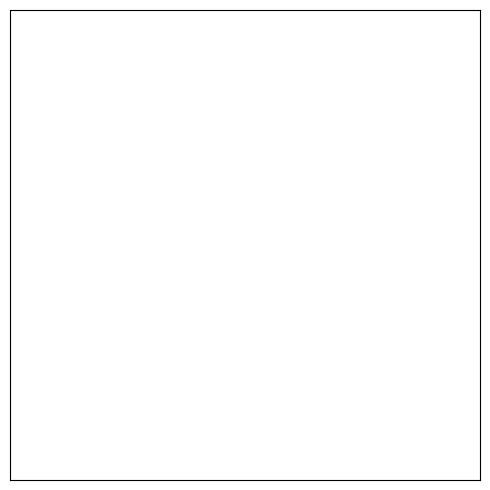

In [4]:
if __name__ == "__main__":
    ## Simulation with DWA Controller 
    delta_t = 0.1  # [sec]
    sim_steps = 150  # [steps]
    # obstacle params
    OBSTACLE_CIRCLES = np.array([
        [+ 8.0, +5.0, 1.0],  # pos_x, pos_y, radius [m] in the global frame
        [+18.0, -5.0, 1.5],  # pos_x, pos_y, radius [m] in the global frame
    ])
    # initialize a differential drive robot as a control target
    robot = DifferentialDriveRobot(
        wheel_base=0.5,
        max_linear_vel=2.0,  # [m/s]
        max_angular_vel=2.0,  # [rad/s]
        obstacle_circles=OBSTACLE_CIRCLES,  # [obs_x, obs_y, obs_radius]
    )
    robot.reset(init_state=np.array([0.0, 0.0, 0.0]))
    
    # initialize a dwa controller for the differential drive robot
    dwa = DWAControllerForDifferentialDrive(
        delta_t=delta_t,  # [s]
        wheel_base=0.5,  # [m]
        max_linear_vel=2.0,  # [m/s]
        max_angular_vel=2.0,  # [rad/s]
        max_linear_accel=1.0,  # [m/s²]
        max_angular_accel=2.0,  # [rad/s²]
        prediction_time=2.0,  # [s]
        velocity_resolution=0.1,  # [m/s]
        angular_resolution=0.1,  # [rad/s]
        goal_cost_weight=1.0,
        obstacle_cost_weight=2.0,
        velocity_cost_weight=0.1,
        visualize_sampled_trajs=True,
        visualize_optimal_traj=True,
        obstacle_circles=OBSTACLE_CIRCLES,  # [obs_x, obs_y, obs_radius]
        collision_safety_margin_rate=1.2,  # safety margin for collision check
    )

    # simulation loop
    for i in range(sim_steps):
        # get current state of robot
        current_state = robot.get_state()

        try:
            # calculate input with DWA
            optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = dwa.calc_control_input(observed_x=current_state)
        except Exception as e:
            print(f"[ERROR] Exception detected: {e}. Terminate simulation.")
            break

        # update states of robot
        robot.update(u=optimal_input, delta_t=delta_t, optimal_traj=optimal_traj[:, 0:2], sampled_traj_list=sampled_traj_list[:, :, 0:2])
        
        # stop when goal is reached
        goal_position = dwa.goal[:2]  # get goal's (x, y)
        pos_error = np.linalg.norm(current_state[:2] - goal_position)
        if pos_error < 0.5:
            print(f"[INFO] Goal reached at step {i}. Terminating simulation.")
            break

    # show animation
    robot.show_animation(interval_ms=int(delta_t * 1000))